<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [122]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)
from matplotlib import pyplot as plt

In [39]:
data = pd.read_csv('clean.csv')
classes_cols = [
    'class_Djembe',
    'class_Timbales',
    'class_Clave',
    'class_Agogo',
    'class_Bongo',
    'class_Tambourin',
    'class_Shaken',
    'class_Conga',
    'class_Cowbell',
    'class_Clap',
    'class_Cymbal',
    'class_Tom',
    'class_Hat',
    'class_Kick',
    'class_Snare'
]
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [40]:
data.shape

(7998, 45)

In [41]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,subclass_Cymbal_Ride,...,subclass_Shaken_Maracas,class_Cajon,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Trash
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

In [43]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [44]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in files:
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb)

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

In [45]:
vgg_embeddings.shape, yam_embeddings.shape

((7998, 1, 128), (7998, 2, 1024))

In [46]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 2*1024)

array([12, 13, 13, ..., 11, 14, 11])

In [113]:
# x_train, x_valid, y_train, y_valid = train_test_split(sounds, classes, test_size=0.3, stratify=classes)
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid = train_test_split(vgg_embeddings, yam_embeddings, classes, test_size=0.3, stratify=classes)

In [114]:
x_vgg_train.shape

(5598, 128)

In [126]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_14 (Dense)             (None, 15)                1515      
Total params: 14,415
Trainable params: 14,415
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))
history = model.fit(x_vgg_train, y_train, epochs=100, validation_data=(x_vgg_valid, y_valid))

Epoch 1/100
175/175 [==============================] - 0s 1ms/step - loss: 1.4933 - accuracy: 0.5457 - val_loss: 1.0863 - val_accuracy: 0.6571
Epoch 2/100
175/175 [==============================] - 0s 953us/step - loss: 0.9667 - accuracy: 0.6942 - val_loss: 0.8788 - val_accuracy: 0.7142
Epoch 3/100
175/175 [==============================] - 0s 963us/step - loss: 0.8299 - accuracy: 0.7310 - val_loss: 0.8018 - val_accuracy: 0.7383
Epoch 4/100
175/175 [==============================] - 0s 963us/step - loss: 0.7643 - accuracy: 0.7504 - val_loss: 0.7615 - val_accuracy: 0.7425
Epoch 5/100
175/175 [==============================] - 0s 958us/step - loss: 0.7229 - accuracy: 0.7572 - val_loss: 0.7217 - val_accuracy: 0.7579
Epoch 6/100
175/175 [==============================] - 0s 943us/step - loss: 0.6890 - accuracy: 0.7685 - val_loss: 0.7112 - val_accuracy: 0.7579
Epoch 7/100
175/175 [==============================] - 0s 957us/step - loss: 0.6666 - accuracy: 0.7746 - val_loss: 0.6856 - val_accu

175/175 [==============================] - 0s 1ms/step - loss: 0.3211 - accuracy: 0.8976 - val_loss: 0.5208 - val_accuracy: 0.8379
Epoch 58/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.9018 - val_loss: 0.5129 - val_accuracy: 0.8450
Epoch 59/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3166 - accuracy: 0.9010 - val_loss: 0.5217 - val_accuracy: 0.8371
Epoch 60/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3106 - accuracy: 0.9000 - val_loss: 0.5171 - val_accuracy: 0.8417
Epoch 61/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3118 - accuracy: 0.9053 - val_loss: 0.5078 - val_accuracy: 0.8392
Epoch 62/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3099 - accuracy: 0.8998 - val_loss: 0.5215 - val_accuracy: 0.8383
Epoch 63/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3021 - accuracy: 0.9060 - val_loss: 0.5014 - val_accuracy: 0.8512
Epoch

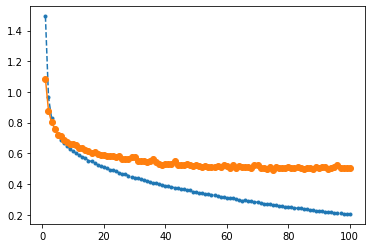

In [129]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [130]:
y_pred = model.predict(x_vgg_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_pred_cls = [ classes_cols[i] for i in y_pred]

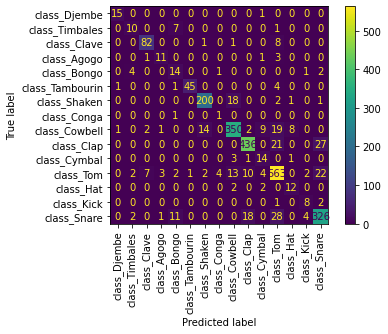

In [131]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_pred_cls, y_valid.idxmax(axis=1)),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [132]:
print(classification_report(y_pred_cls, y_valid.idxmax(axis=1)))

                 precision    recall  f1-score   support

    class_Agogo       0.88      0.94      0.91        16
    class_Bongo       0.56      0.56      0.56        18
     class_Clap       0.89      0.89      0.89        92
    class_Clave       0.69      0.69      0.69        16
    class_Conga       0.39      0.64      0.48        22
  class_Cowbell       0.98      0.88      0.93        51
   class_Cymbal       0.92      0.90      0.91       222
   class_Djembe       0.17      0.50      0.25         2
      class_Hat       0.90      0.86      0.88       406
     class_Kick       0.93      0.90      0.92       484
   class_Shaken       0.45      0.74      0.56        19
    class_Snare       0.87      0.89      0.88       635
class_Tambourin       0.55      0.75      0.63        16
 class_Timbales       0.53      0.73      0.62        11
      class_Tom       0.86      0.84      0.85       390

       accuracy                           0.87      2400
      macro avg       0.70   

In [133]:
inputs = Input(shape=(2048))
x = Dense(100, activation='relu')(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_16 (Dense)             (None, 15)                1515      
Total params: 206,415
Trainable params: 206,415
Non-trainable params: 0
_________________________________________________________________


In [136]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
175/175 [==============================] - 0s 2ms/step - loss: 1.5795 - accuracy: 0.4805 - val_loss: 1.2837 - val_accuracy: 0.5133
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 1.1865 - accuracy: 0.5970 - val_loss: 1.1783 - val_accuracy: 0.6313
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 1.0077 - accuracy: 0.6576 - val_loss: 1.0074 - val_accuracy: 0.6679
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 0.9123 - accuracy: 0.6856 - val_loss: 0.9249 - val_accuracy: 0.6775
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 0.8615 - accuracy: 0.7061 - val_loss: 0.8870 - val_accuracy: 0.6983
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 0.7970 - accuracy: 0.7233 - val_loss: 0.7975 - val_accuracy: 0.7371
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 0.7479 - accuracy: 0.7424 - val_loss: 0.8986 - val_accuracy: 0.6888

Epoch 58/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8667 - val_loss: 0.6810 - val_accuracy: 0.8146
Epoch 59/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8671 - val_loss: 0.8032 - val_accuracy: 0.7725
Epoch 60/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8700 - val_loss: 0.7969 - val_accuracy: 0.7738
Epoch 61/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.8700 - val_loss: 0.6948 - val_accuracy: 0.8079
Epoch 62/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.8687 - val_loss: 0.7221 - val_accuracy: 0.7971
Epoch 63/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8758 - val_loss: 0.6794 - val_accuracy: 0.8058
Epoch 64/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8685 - val_loss: 0.7408 - val_accuracy:

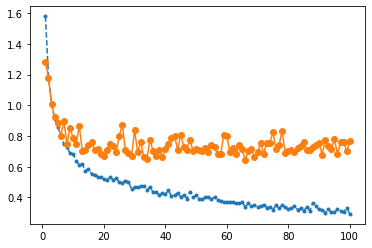

In [138]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [140]:
y_pred = model2.predict(x_yam_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_pred_cls = [ classes_cols[i] for i in y_pred]

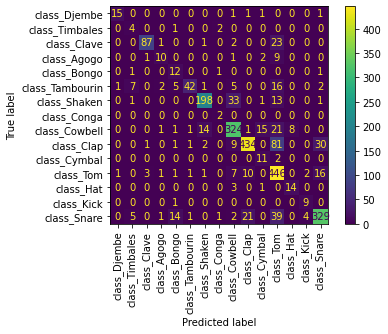

In [141]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_pred_cls, y_valid.idxmax(axis=1)),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [142]:
print(classification_report(y_pred_cls, y_valid.idxmax(axis=1)))

                 precision    recall  f1-score   support

    class_Agogo       0.88      0.79      0.83        19
    class_Bongo       0.22      0.57      0.32         7
     class_Clap       0.95      0.76      0.84       114
    class_Clave       0.62      0.43      0.51        23
    class_Conga       0.33      0.80      0.47        15
  class_Cowbell       0.91      0.52      0.66        81
   class_Cymbal       0.91      0.80      0.85       247
   class_Djembe       0.33      1.00      0.50         2
      class_Hat       0.84      0.84      0.84       386
     class_Kick       0.93      0.78      0.85       559
   class_Shaken       0.35      0.85      0.50        13
    class_Snare       0.69      0.91      0.78       489
class_Tambourin       0.64      0.78      0.70        18
 class_Timbales       0.60      0.90      0.72        10
      class_Tom       0.87      0.79      0.83       417

       accuracy                           0.81      2400
      macro avg       0.67   